In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
from tqdm import tqdm, trange

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

import pyvene
from pyvene import CausalModel
from pyvene.models.mlp.modelings_mlp import MLPConfig
from pyvene import create_mlp_classifier
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## Causal model

In [118]:
embedding_dim = 2
number_of_entities = 20

def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])

def all_possible_sums(values1, values2):
    l = list(itertools.product(values1, values2))
    return [sum(i) for i in l]

# variables
variables = ['X', 'Y', 'Z', 'S1', 'W', 'S2']

# all possible values of variables
reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]
values = {variable: reps for variable in ['X', 'Y', 'Z']}
values['W'] = values['Z']
values['S1'] = all_possible_sums(values['X'], values['Y'])
values['S2'] = all_possible_sums(values['S1'], values['W'])

# parents
parents = {
    'X': [],
    'Y': [],
    'Z': [],
    'S1': ['X', 'Y'],
    'W': ['Z'],
    'S2': ['S1', 'W'],
}

# functions
def FILLER():
    return reps[0]

# function at each node
functions = {
    'X': FILLER,
    'Y': FILLER,
    'Z': FILLER,
    # inputs are all the parents (children if arrows are reversed)
    'S1': lambda x, y: x + y,
    'W': lambda x: x,
    'S2': lambda x, y: x + y,
}

# a dictionary with nodes as keys and positions as values
pos = {
    'X': (0.5, 0),
    'Y': (1.5, 0),
    'Z': (2.5, 0),
    'S1': (1.1, 1),
    'W': (2.2, 1),
    'S2': (1.7, 2),
}

In [119]:
sum_model = CausalModel(variables, values, parents, functions, pos=pos)

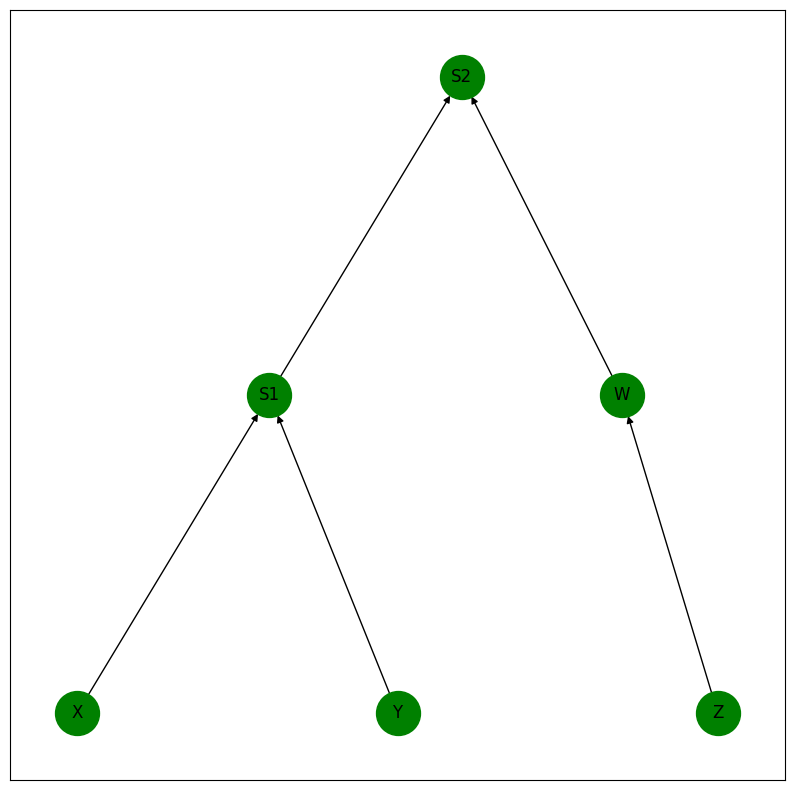

Timesteps: {'X': 0, 'Y': 0, 'Z': 0, 'S1': 1, 'W': 1, 'S2': 2}


In [120]:
sum_model.print_structure()
print("Timesteps:", sum_model.timesteps)

### No intervention

No intervention:
 defaultdict(None, {'X': array([-0.79,  0.69]), 'Y': array([ 0.7 , -0.43]), 'Z': array([ 0.53, -0.45]), 'S1': array([-0.09,  0.26]), 'W': array([ 0.53, -0.45]), 'S2': array([ 0.44, -0.19])}) 



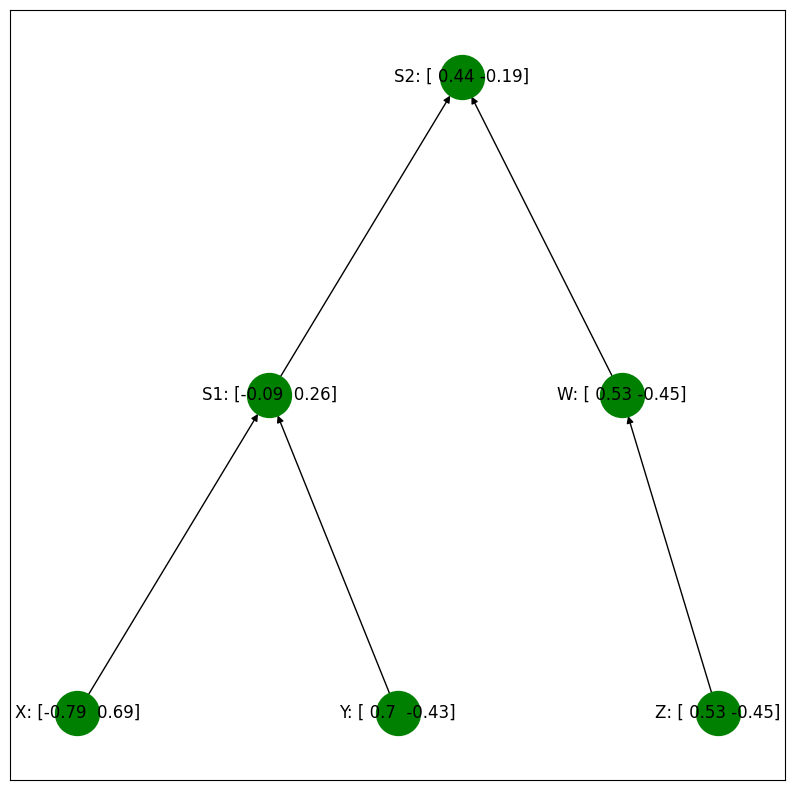

In [121]:
setting = sum_model.run_forward({'X': reps[0], 'Y': reps[1], 'Z': reps[2]})

print("No intervention:\n", setting, "\n")
equality_model.print_setting(setting)

### With intervention at S1

[ 0.81 -0.71] at S1
With intervention:
 defaultdict(None, {'X': array([-0.79,  0.69]), 'Y': array([ 0.7 , -0.43]), 'Z': array([ 0.53, -0.45]), 'S1': array([ 0.81, -0.71]), 'W': array([ 0.53, -0.45]), 'S2': array([ 1.34, -1.16])}) 



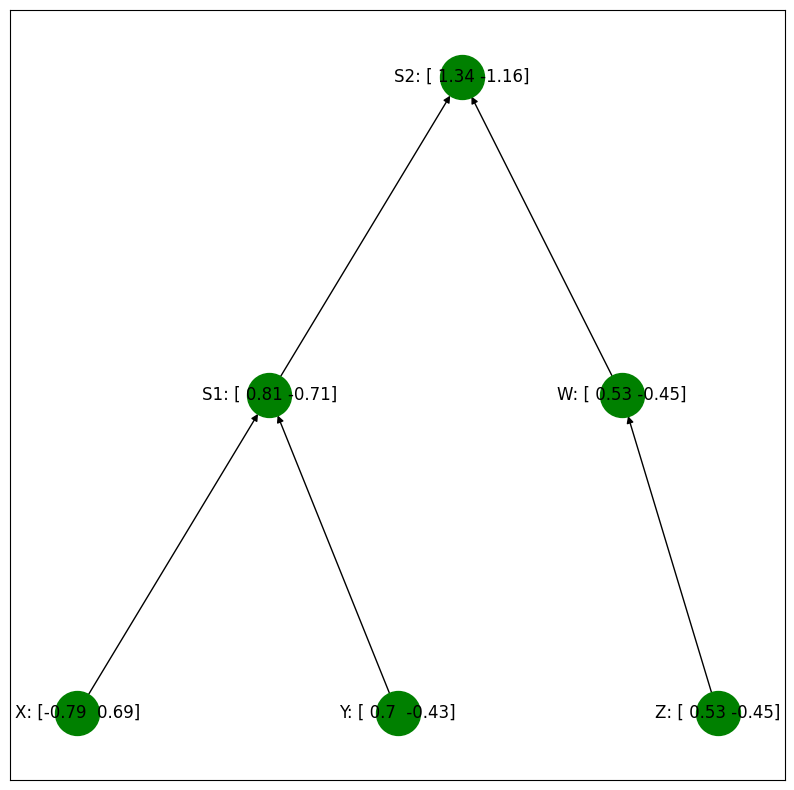

In [123]:
print("{} at S1".format(reps[3]))
setting = sum_model.run_forward({'X': reps[0], 'Y': reps[1], 'Z': reps[2], 'S1': reps[3]})

print("With intervention:\n", setting, "\n")
equality_model.print_setting(setting)

### Interchange intervention at S1

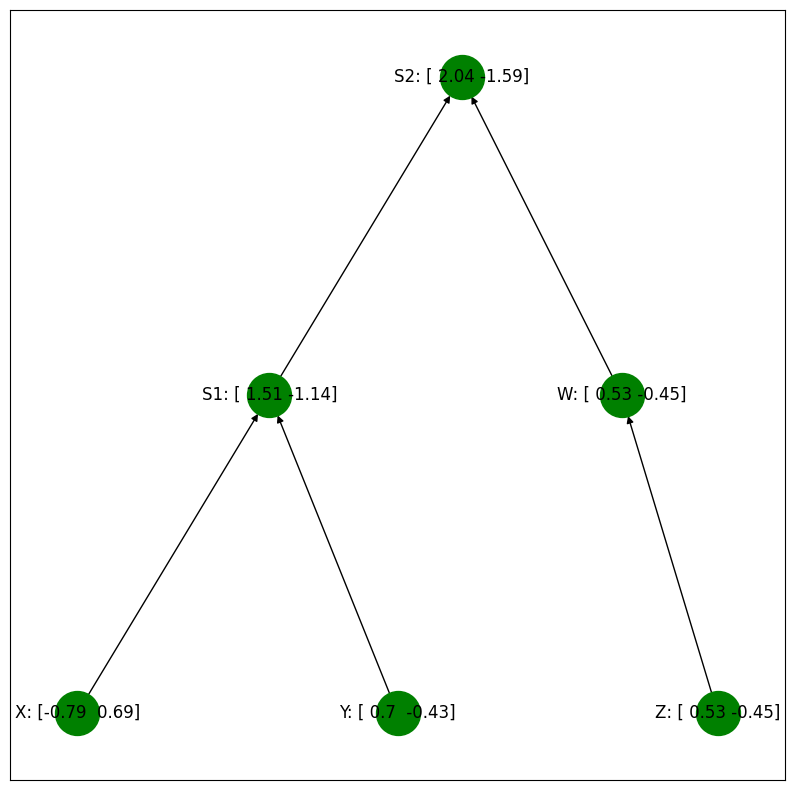

In [126]:
base = {'X': reps[0], 'Y': reps[1], 'Z': reps[2]}
source = {'X': reps[3], 'Y': reps[1], 'Z': reps[3]}

setting = sum_model.run_interchange(base, {'S1': source})
sum_model.print_setting(setting)

## Training an MLP

In [130]:
randvec(4)

array([ 0.57,  0.02, -0.96,  0.75])

In [127]:
# define an input sampler to provide an infinite stream of new entities,
# rather than relying on a fixed set of vector representations

embedding_dim = 4


def input_sampler():
    A = randvec(embedding_dim)
    B = randvec(embedding_dim)
    C = randvec(embedding_dim)
    x = random.randint(1, 3)
    if x == 1:
        return {"X": A, "Y": B, "Z": C}
    elif x == 2:
        return {"X": B, "Y": C, "Z": A}
    elif x == 3:
        return {"X": C, "Y": A, "Z": B}

In [128]:
n_examples = 1048576
batch_size = 1024

examples = equality_model.generate_factual_dataset(n_examples, input_sampler)

X = torch.stack([example['input_ids'] for example in examples])
y = torch.stack([example['labels'] for example in examples])

TypeError: only length-1 arrays can be converted to Python scalars